# AstraZeneca Sentiment Analysis

In [1]:
from tqdm import tqdm
import pandas as pd
from functools import reduce
from io import open
import json
from datetime import date,datetime, timedelta
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle("../full_db.pkl")

ANALYZE_DAYS = False

df = df[df.entities.str.len()>0]
df = df[~df.sentiment_value.isna()]
df = df[df.created_at < "2021-09-07"]

df.created_at = pd.to_datetime(df.created_at)
df["ym"] = df.created_at.astype(str).str[:-3]
df["roberta_label"] = df.sentiment_value.apply(lambda row: row["label"])

data = []
for _date, d in df[df.vaccines.apply(lambda row: "astrazeneca" in row)].groupby("created_at"):

    vc = d.roberta_label.value_counts()
    
    item = {
        "date": _date,
        "pos_sum": vc["LABEL_2"] / len(d) if "LABEL_2" in vc else 0,
        "neu_sum": vc["LABEL_1"] / len(d) if "LABEL_1" in vc else 0,
        "neg_sum": vc["LABEL_0"] / len(d) if "LABEL_0" in vc else 0,
    }

    data.append(item)
    
data = pd.DataFrame(data)


data.index = data.date
data.drop("date", axis=1, inplace = True)


data["pos_ewm"] = data.pos_sum.ewm(halflife = "4 days", times=pd.DatetimeIndex(data.index)).mean()
data["neu_ewm"] = data.neu_sum.ewm(halflife = "4 days", times=pd.DatetimeIndex(data.index)).mean()
data["neg_ewm"] = data.neg_sum.ewm(halflife = "4 days", times=pd.DatetimeIndex(data.index)).mean()


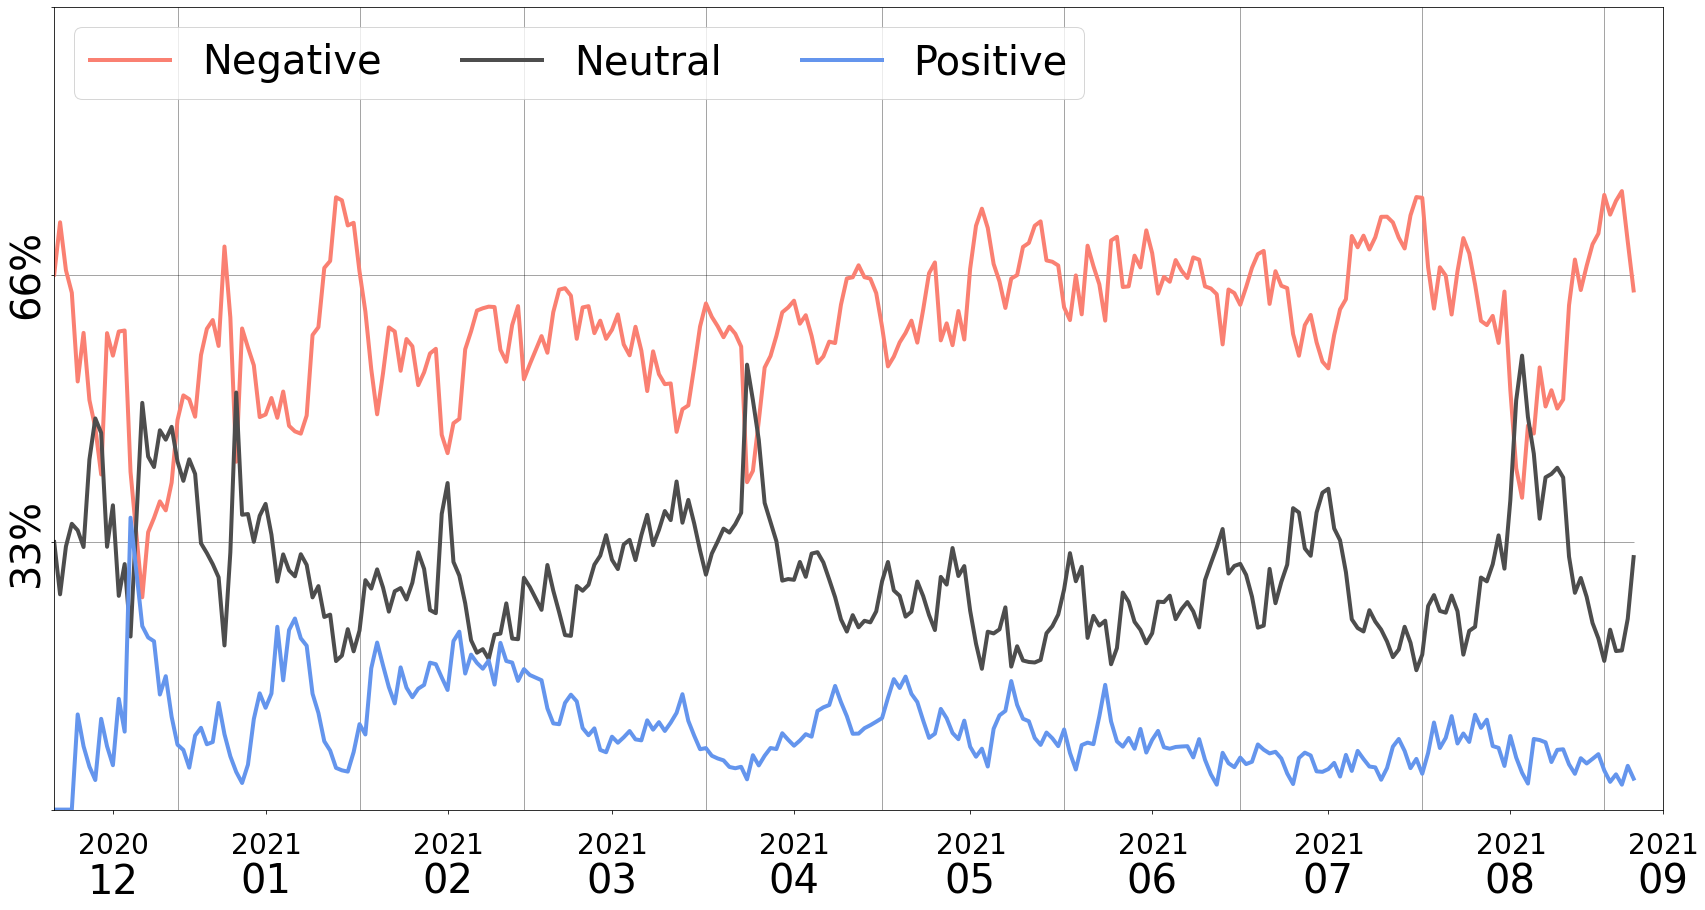

In [3]:
plt.rcParams.update({'font.size': 40})
plt.figure(figsize=(25,13))

NUM_DAYS = 2

data["pos_ewm"] = data.pos_sum.ewm(halflife = f"{NUM_DAYS} days", times=pd.DatetimeIndex(data.index)).mean()
data["neu_ewm"] = data.neu_sum.ewm(halflife = f"{NUM_DAYS} days", times=pd.DatetimeIndex(data.index)).mean()
data["neg_ewm"] = data.neg_sum.ewm(halflife = f"{NUM_DAYS} days", times=pd.DatetimeIndex(data.index)).mean()

plt.vlines([x for x in data.index if x.day==1], ymin=0, ymax=1, color="k", lw=.5, alpha=.7)
plt.hlines([1/3, 2/3], xmin=data.index[0], xmax=data.index[-1], color="k", lw=.5, alpha=.7)

plt.plot(data.index, data.neg_ewm, label="Negative", color="salmon", linewidth=4)
plt.plot(data.index, data.neu_ewm, label="Neutral", color="0.3", linewidth=4)
plt.plot(data.index, data.pos_ewm, label="Positive", color="cornflowerblue", linewidth=4)
# mediumspringgreen, cornflowerblue
ax = plt.gca()



plt.ylim(0,1)
plt.xlim(data.index[0],data.index[-1])

plt.yticks([0,1/3,2/3,1], ["", "33%", "66%", ""], rotation=90)

plt.yticks(va="center")
plt.xticks(ha="center")

plt.legend(ncol=3, loc="upper left")
plt.tight_layout()

ticks, labels = plt.xticks()
plt.xticks(
    [plt.xlim()[0]+10]+[x+15 for x in ticks[:-1]]+[ticks[-1]+10],
    ["$_{"+x.split("-")[0]+"}$\n"+x.split("-")[1] for x in ["2020-12"]+[y.get_text() for y in labels]]
)

plt.savefig("output/plot_astrazeneca_sentiment.pdf")
plt.show()